In [1]:
%load_ext autoreload
%autoreload 2

import os, sys

from skimage.io import imread
from skimage.exposure import rescale_intensity
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [2]:
stack = 'MD657'
_, sec2fn = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]

# Match histograms between Nissl and Neurotrace

In [3]:
def match_histogram(source, template):
    """
    Returns: 
        s_values (array): unique source values
        interp_t_values (array): unique destination values
    """
    
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return s_values, interp_t_values

In [4]:
# def hist_match(source, template):
#     """
#     Adjust the pixel values of a grayscale image such that its histogram
#     matches that of a target image

#     Arguments:
#     -----------
#         source: np.ndarray
#             Image to transform; the histogram is computed over the flattened
#             array
#         template: np.ndarray
#             Template image; can have different dimensions to source
#     Returns:
#     -----------
#         matched: np.ndarray
#             The transformed output image
#     """
#     # http://stackoverflow.com/a/33047048

#     oldshape = source.shape
#     source = source.ravel()
#     template = template.ravel()

#     # get the set of unique pixel values and their corresponding indices and
#     # counts
#     s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
#                                             return_counts=True)
#     t_values, t_counts = np.unique(template, return_counts=True)

#     # take the cumsum of the counts and normalize by the number of pixels to
#     # get the empirical cumulative distribution functions for the source and
#     # template images (maps pixel value --> quantile)
#     s_quantiles = np.cumsum(s_counts).astype(np.float64)
#     s_quantiles /= s_quantiles[-1]
#     t_quantiles = np.cumsum(t_counts).astype(np.float64)
#     t_quantiles /= t_quantiles[-1]

#     # interpolate linearly to find the pixel values in the template image
#     # that correspond most closely to the quantiles in the source image
#     interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

#     return interp_t_values[bin_idx].reshape(oldshape)

In [5]:
nissl_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'N' and sec > first_sec and sec < last_sec]
ntb_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'F' and sec > first_sec and sec < last_sec]

In [6]:
# Generate nissl-nissl pairs.

# compare_pairs = []
# for nissl_sec in nissl_sections:
#     for i in range(1, 10):
#         closest_nissl_sec = nissl_sec + i
#         if closest_nissl_sec in nissl_sections:
#             break
#     compare_pairs.append((nissl_sec, closest_nissl_sec))

In [7]:
# Generate nissl-ntb pairs.

compare_pairs = []
for nissl_sec in nissl_sections:
    for i in range(1, 10):
        closest_ntb_sec = nissl_sec + i
        if closest_ntb_sec in ntb_sections:
            break
    compare_pairs.append((nissl_sec, closest_ntb_sec))

In [8]:
w, h = metadata_cache['image_shape'][stack]

# Same region, different images.

In [ ]:
# Sample the region bbox.

while True:
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    region1_x = np.random.randint(0, w-10000, 1)[0]
    region1_y = np.random.randint(0, h-10000, 1)[0]
    region1_w = 5000
    region1_h = 5000
    print region1_x, region1_y, region1_w, region1_h

    tb_region1_xmin = region1_x / 32
    tb_region1_xmax = (region1_x + region1_w) / 32
    tb_region1_ymin = region1_y / 32
    tb_region1_ymax = (region1_y + region1_h) / 32

    if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
    nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
    nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
    nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
        break

In [ ]:
ntb_matched_values_all_examples = []

for nissl_sec, ntb_sec in compare_pairs[:10]:
    
    ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
    download_from_s3(ntb_im_fp)
    ntb_im = imread(ntb_im_fp)
    ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
    ntb_blue_region1 = 3000 - ntb_blue_region1
    
    ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
    ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
    nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
    download_from_s3(nissl_im_fp)
    nissl_im = imread(nissl_im_fp)
    nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))
    
    nissl_gray_bins = np.arange(0, 257)
    nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
    
    ###############
    
    ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    axes[0].imshow(nissl_region1, plt.cm.gray);
    axes[0].set_title('Nissl');
    axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    axes[1].set_title('Neurotrace (histogram matched)');
    plt.show();
    
    ntb_to_nissl = {}
    for ntb_v in ntb_blue_bins[:-1]:
        a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
        if len(a) > 0:
            ntb_to_nissl[ntb_v] = np.unique(a)[0]

    ntb_values = np.arange(0, 5000)
    ntb_matched_values = np.interp(ntb_values, 
                                   [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                   [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])
    
    ntb_matched_values_all_examples.append(ntb_matched_values)

    plt.plot(ntb_values, ntb_matched_values);
    plt.xlim([0,5000]);
    plt.ylim([0,256]);
    plt.xlabel('Neurotrace intensity');
    plt.ylabel('Matched nissl intensity');
    plt.show();

In [ ]:
plt.figure(figsize=(10,5));
for a in ntb_matched_values_all_examples:
    plt.plot(ntb_values, a);
plt.xlim([0,5000]);
plt.ylim([0,256]);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Matched nissl intensity');
plt.show();

In [ ]:
# Show that intensities of two modalities are not in exact one-to-one correspondence.

ntb_to_nissl = {}
for ntb_v in ntb_blue_bins[:-1]:
    a = nissl_region1[ntb_blue_region1 == ntb_v]
    if len(a) > 0:
#         ntb_to_nissl[ntb_v] = np.unique(a)[0]
        plt.hist(a, bins=np.arange(256));
        plt.title('%d' % ntb_v);
        plt.xlabel('Nissl intensity');
        plt.xlabel('Distribution of Neurotrace intensities at corresponding pixels.');
        plt.show();

# Explore red and green channels

In [ ]:
from skimage.exposure import rescale_intensity
from skimage.exposure import equalize_hist

In [ ]:
plt.figure(figsize=(20,20));
q = rescale_intensity(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0],
                     (0, 400))
plt.imshow(q, 
           vmin=0, vmax=q.max(),
          cmap=plt.cm.gray);

In [ ]:
plt.figure(figsize=(20,20));
q = equalize_hist(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0])
plt.imshow(q, 
           vmin=0, vmax=q.max(),
          cmap=plt.cm.gray);

In [ ]:
plt.figure(figsize=(20,20));
plt.imshow(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0], 
           vmin=0, vmax=ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0].max(),
          cmap=plt.cm.gray);

In [ ]:
red_imin = 0
red_imax = 75
green_imin = 0
green_imax = 85

In [ ]:
mg_red_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0]].astype(np.uint8)
img_green_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 1]].astype(np.uint8)
img_blue_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]].astype(np.uint8)

In [ ]:
ntb_img_rgb = np.zeros(ntb_blue_region1.shape[:2] + (3,), np.uint8)
ntb_img_rgb[..., 0] = img_red_intensity_normalized
ntb_img_rgb[..., 1] = img_green_intensity_normalized
ntb_img_rgb[..., 2] = img_blue_intensity_normalized

In [ ]:
plt.figure(figsize=(10,10));
plt.imshow(ntb_img_rgb, cmap=plt.cm.gray);

# Same images, different regions. nissl-ntblue

## Parallel

In [ ]:
def f(nissl_sec, ntb_sec):
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    for region_id in range(10):

        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
        
        t = time.time()
        
        ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
        download_from_s3(ntb_im_fp)
        ntb_im = imread(ntb_im_fp)
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        ntb_blue_region1 = 3000 - ntb_blue_region1

        ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
        
        sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

        t = time.time()

        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
        
        sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)

    #     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    #     axes[0].imshow(nissl_region1, plt.cm.gray);
    #     axes[0].set_title('Nissl');
    #     axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    #     axes[1].set_title('Neurotrace (histogram matched)');
    #     plt.show();
        ntb_to_nissl = {}
        for ntb_v in ntb_blue_bins[:-1]:
            a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
            if len(a) > 0:
                ntb_to_nissl[ntb_v] = np.unique(a)[0]

        ntb_values = np.arange(0, 5000)
        ntb_matched_values = np.interp(ntb_values, 
                                       [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                       [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])

        ntb_matched_values_all_examples_one_section.append(ntb_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))

        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
#         ntb_matched_values_all_examples[(nissl_sec, ntb_sec)].append(ntb_matched_values)
#         region_bboxes_all_examples[(nissl_sec, ntb_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_matched_values.npy' % (ntb_sec, nissl_sec))
    np.save(fp, ntb_matched_values_all_examples_one_section)
    upload_to_s3(fp)

    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_region_bboxes.npy' % (ntb_sec, nissl_sec))
    np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp)

In [ ]:
from multiprocess import Pool

pool = Pool(NUM_CORES/2)
pool.map(lambda (nissl_sec, ntb_sec): f( nissl_sec, ntb_sec), compare_pairs)
pool.close()
pool.join()

## Sequential

In [ ]:
# ntb_matched_values_all_examples = defaultdict(list)
# region_bboxes_all_examples = defaultdict(list)

for nissl_sec, ntb_sec in compare_pairs[37:38]:
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')

    for region_id in range(10):
        
        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
        
        t = time.time()
        
        ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
        download_from_s3(ntb_im_fp)
        ntb_im = imread(ntb_im_fp)
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        ntb_blue_region1 = 3000 - ntb_blue_region1

        ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
        sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

        t = time.time()
        
        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]

        sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
        axes[0].imshow(nissl_region1, plt.cm.gray);
        axes[0].set_title('Nissl');
        axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
        axes[1].set_title('Neurotrace (histogram matched)');
        plt.show();

        ntb_to_nissl = {}
        for ntb_v in ntb_blue_bins[:-1]:
            a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
            if len(a) > 0:
                ntb_to_nissl[ntb_v] = np.unique(a)[0]

        ntb_values = np.arange(0, 5000)
        ntb_matched_values = np.interp(ntb_values, 
                                       [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                       [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])

    #     ntb_matched_values_all_examples.append(ntb_matched_values)

        ntb_matched_values_all_examples_one_section.append(ntb_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))
    
#         ntb_matched_values_all_examples[(nissl_sec, ntb_sec)].append(ntb_matched_values)
#         region_bboxes_all_examples[(nissl_sec, ntb_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))

        
#     fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_matched_values.npy' % (ntb_sec, nissl_sec))
#     np.save(fp, ntb_matched_values_all_examples_one_section)
#     upload_to_s3(fp)

#     fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_region_bboxes.npy' % (ntb_sec, nissl_sec))
#     np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
#     upload_to_s3(fp)
    
    #     plt.plot(ntb_values, ntb_matched_values);
    #     plt.xlim([0,5000]);
    #     plt.ylim([0,256]);
    #     plt.xlabel('Neurotrace intensity');
    #     plt.ylabel('Matched nissl intensity');
    #     plt.show();

# One image pair, different regions (NEW)

In [ ]:
# Find the maximal intensity in fluorescent blue channel.

# for fn in metadata_cache['valid_filenames'][stack][::10]:
#     if fn.split('-')[1][0] == 'F':
#         im = DataManager.load_image(stack=stack, fn=fn, version='cropped_16bit', resol='lossless')[..., 2]
#         print fn, im.min(), im.max()

In [9]:
def rescale_intensity_v2(im, low, high):
    if low > high:
        im_out = rescale_intensity(low-im.astype(np.int), (0, low-high), (0, 255)).astype(np.uint8)
    else:
        im_out = rescale_intensity(im.astype(np.int), (low, high), (0, 255)).astype(np.uint8)
    return im_out

In [10]:
[(i, metadata_cache['sections_to_filenames'][stack][ntb_sec]) for i, (nissl_sec, ntb_sec) in enumerate(compare_pairs)]

[(0, 'MD657-F14-2017.02.17-20.29.47_MD657_1_0040'),
 (1, 'MD657-F14-2017.02.17-20.29.47_MD657_2_0041'),
 (2, 'MD657-F14-2017.02.17-20.29.47_MD657_3_0042'),
 (3, 'MD657-F15-2017.02.17-20.46.06_MD657_1_0043'),
 (4, 'MD657-F15-2017.02.17-20.46.06_MD657_2_0044'),
 (5, 'MD657-F15-2017.02.17-20.46.06_MD657_3_0045'),
 (6, 'MD657-F16-2017.02.17-21.02.17_MD657_1_0046'),
 (7, 'MD657-F16-2017.02.17-21.02.17_MD657_2_0047'),
 (8, 'MD657-F16-2017.02.17-21.02.17_MD657_3_0048'),
 (9, 'MD657-F17-2017.02.17-21.22.26_MD657_1_0049'),
 (10, 'MD657-F17-2017.02.17-21.22.26_MD657_2_0050'),
 (11, 'MD657-F17-2017.02.17-21.22.26_MD657_3_0051'),
 (12, 'MD657-F18-2017.02.17-21.43.03_MD657_1_0052'),
 (13, 'MD657-F18-2017.02.17-21.43.03_MD657_2_0053'),
 (14, 'MD657-F18-2017.02.17-21.43.03_MD657_3_0054'),
 (15, 'MD657-F19-2017.02.17-22.03.48_MD657_1_0055'),
 (16, 'MD657-F19-2017.02.17-22.03.48_MD657_2_0056'),
 (17, 'MD657-F19-2017.02.23-16.16.58_MD657_3_0057'),
 (18, 'MD657-F20-2017.02.17-22.23.13_MD657_1_0058'),
 (1

nissl 151, ntb 152
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2546: UserWarning: unpack: string size must be a multiple of element size
  warnings.warn("unpack: %s" % e)
Load NTB: 21.45 seconds.
Load Nissl: 15.85 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


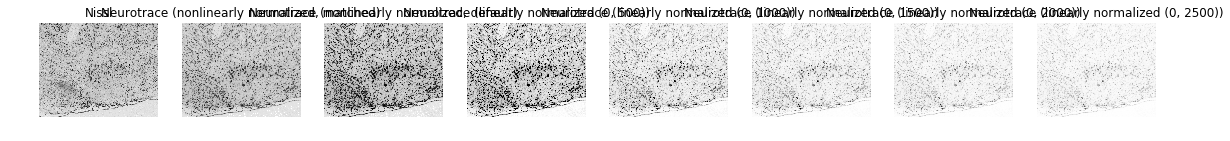

In [11]:
for nissl_sec, ntb_sec in compare_pairs[35:36]:
    
    sys.stderr.write('nissl %d, ntb %d\n' % (nissl_sec, ntb_sec))
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
    ntb_im = DataManager.load_image(stack=stack, section=ntb_sec, version='cropped', resol='lossless')
    sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

    t = time.time()
    nissl_im = DataManager.load_image(stack=stack, section=nissl_sec, version='cropped', resol='lossless')
    sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

#     h, w = nissl_im.shape[:2]
#     for region_id in range(3):
#         while True:
#             region_w = 5000
#             region_h = 5000
#             region_x = np.random.randint(0, w - region_w, 1)[0]
#             region_y = np.random.randint(0, h - region_h, 1)[0]
            
#             tb_region_xmin = region_x / 32
#             tb_region_xmax = (region_x + region_w) / 32
#             tb_region_ymin = region_y / 32
#             tb_region_ymax = (region_y + region_h) / 32
            
#             if np.all(np.r_[nissl_tb_mask[tb_region_ymin, tb_region_xmin],
#             nissl_tb_mask[tb_region_ymin, tb_region_xmax],
#             nissl_tb_mask[tb_region_ymax, tb_region_xmin],
#             nissl_tb_mask[tb_region_ymax, tb_region_xmax]]):
#                 break
        
#         sys.stderr.write('%d %d %d %d\n' % (region_x, region_y, region_w, region_h))
    
    for region_id in range(1):
        region_x = 233 * 32
        region_y = 299 * 32
        region_w = 124 * 32
        region_h = 98 * 32
    
        ntb_blue_region = ntb_im[region_y:region_y+region_h, region_x:region_x+region_w, 2]
        
        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
        ntb_blue_bins = np.arange(5001)
        ntb_blue_hist = np.histogram(ntb_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
        
        ntb_blue_inv_bins = np.arange(5001)
        ntb_blue_inv_hist = np.histogram(5000 - ntb_blue_region.flatten(), bins=np.r_[ntb_blue_inv_bins, 5001])[0]
 
        nissl_region = img_as_ubyte(rgb2gray(nissl_im[region_y:region_y+region_h, region_x:region_x+region_w]))
        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region.flatten(), bins=nissl_gray_bins)[0]        

        ###############

#         t = time.time()

        # Matched mapping
        ntb_blue_region_inv = 5000 - ntb_blue_region.astype(np.int)
        ntb_inv_vals, nissl_vals = match_histogram(ntb_blue_region_inv, nissl_region)
    
        ntb_blue_inv_bins = np.arange(0, 5001)
        ntb_inv_to_nissl_mapping = np.interp(ntb_blue_inv_bins, ntb_inv_vals, nissl_vals)
        
        ntb_to_nissl_mapping = ntb_inv_to_nissl_mapping[5000 - ntb_blue_bins]
        ntb_to_nissl_mapping = np.round(ntb_to_nissl_mapping).astype(np.uint8)

        ntb_region_normalized = np.round(ntb_to_nissl_mapping[ntb_blue_region]).astype(np.uint8)
        
        ntb_blue_normalized_bins = np.arange(0, 257)
        ntb_blue_normalized_hist = np.histogram(ntb_region_normalized.flatten(), bins=np.r_[ntb_blue_normalized_bins, 5001])[0]

#         ntb_matched_values_all_examples_one_section.append(ntb_to_nissl_mapping)
#         region_bboxes_all_examples_one_section.append((region_x, region_y, region_w, region_h))
        
        # Default mapping
        intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
        download_from_s3(intensity_mapping_fp)
        default_ntb_to_nissl_mapping = np.load(intensity_mapping_fp)

        ntb_region_normalized_default = np.round(default_ntb_to_nissl_mapping[ntb_blue_region]).astype(np.uint8)        
        ntb_blue_normalized_bins_default = np.arange(0, 257)
        ntb_blue_normalized_hist_default = np.histogram(ntb_region_normalized_default.flatten(), bins=np.r_[ntb_blue_normalized_bins_default, 5001])[0]
    
#         sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
        # Linear normalizations
        
        ntb_region_linearNormalized_diffClips = {}
        ntb_region_linearNormalized_inverted_diffClips = {}
        
        low = 0
        highs = range(500, 3000, 500)
        for high in highs:
            ntb_region_linearNormalized = rescale_intensity_v2(ntb_blue_region, low, high)
    #         ntb_blue_linearNormalized_bins = np.arange(0, 256)
    #         ntb_blue_linearNormalized_hist = np.histogram(ntb_region_linearNormalized.flatten(), bins=np.r_[ntb_blue_linearNormalized_bins, [257]])[0]

            ntb_region_linearNormalized_inverted = rescale_intensity_v2(ntb_blue_region, high, low)
    #         ntb_blue_linearNormalized_inverted_bins = np.arange(0, 256)
    #         ntb_blue_linearNormalized_inverted_hist = np.histogram(ntb_region_linearNormalized_inverted.flatten(), bins=np.r_[ntb_blue_linearNormalized_inverted_bins, [257]])[0]

    #         ntb_to_nissl_linear_mapping = np.zeros((5001,))
    #         ntb_to_nissl_linear_mapping[:high] = - 255 / float(high) * np.arange(high) + 255
    
            ntb_region_linearNormalized_diffClips[high] = ntb_region_linearNormalized
            ntb_region_linearNormalized_inverted_diffClips[high] = ntb_region_linearNormalized_inverted
        
#         # Plot intensity histograms
        
#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_bins, ntb_blue_hist);
#         plt.xlabel('Neurotrace blue intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_bins, np.log(ntb_blue_hist));
#         plt.xlabel('Neurotrace blue intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.plot(ntb_blue_bins, ntb_to_nissl_mapping);
#         plt.xlabel('Neurotrace intensity');
#         plt.ylabel('Normalized intensity');
#         plt.title('Neurotrace to Brightfield Nissl intensity mapping');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_inv_bins, ntb_blue_inv_hist);
#         plt.xlabel('5000 - Neurotrace blue intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.plot(ntb_blue_inv_bins, ntb_inv_to_nissl_mapping);
#         plt.xlabel('5000 - Neurotrace intensity');
#         plt.ylabel('Normalized intensity');
#         plt.title('Neurotrace to Brightfield Nissl intensity mapping');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
#         plt.xlabel('Nissl intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Nissl Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(nissl_gray_bins[:-1], np.log(nissl_gray_hist));
#         plt.xlabel('Nissl intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Nissl Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_normalized_bins, ntb_blue_normalized_hist);
#         plt.xlabel('Neurotrace blue normalized intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Normalized Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_normalized_bins, np.log(ntb_blue_normalized_hist));
#         plt.xlabel('Neurotrace blue normalized intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Normalized Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.plot(ntb_blue_bins, ntb_to_nissl_linear_mapping);
#         plt.xlabel('Neurotrace intensity');
#         plt.ylabel('Normalized intensity');
#         plt.title('Neurotrace to Brightfield Nissl intensity mapping (Linear)');
#         plt.show();


#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_bins, ntb_blue_linearNormalized_hist);
#         plt.xlabel('Neurotrace blue linearly normalized intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_bins, np.log(ntb_blue_linearNormalized_hist));
#         plt.xlabel('Neurotrace blue linearly normalized intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
#         plt.show();


#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_inverted_bins, ntb_blue_linearNormalized_inverted_hist);
#         plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_inverted_bins, np.log(ntb_blue_linearNormalized_inverted_hist));
#         plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
#         plt.show();      


#         # Separate Figures

# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.imshow(nissl_region, plt.cm.gray);
#         plt.title('Nissl Image, %s' % metadata_cache['sections_to_filenames'][stack][nissl_sec]);
#         plt.axis('off');
#         plt.show();

# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.imshow(ntb_region_normalized, plt.cm.gray);
#         plt.title('Neurotrace Image (Intensity Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
#         plt.axis('off');
#         plt.show();
            
#         for i in range(5):
#     #         plt.figure(figsize=(20,20));
#             plt.figure();
#             plt.imshow(ntb_region_linearNormalized_diffClips[i], plt.cm.gray);
#             plt.title('Neurotrace Image (linearly Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
#             plt.axis('off');
#             plt.show();

#     #         plt.figure(figsize=(20,20));
#             plt.figure();
#             plt.imshow(ntb_region_linearNormalized_inverted_diffClips[i], plt.cm.gray);
#             plt.title('Neurotrace Image (linearly Normalized + inverted), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
#             plt.axis('off');
#             plt.show();
        
        # Subplots
        fig, axes = plt.subplots(ncols=3+len(highs), nrows=1, figsize=(20, 20));
        axes = axes.flatten()
        axes[0].imshow(nissl_region, plt.cm.gray);
        axes[0].set_title('Nissl');
        axes[0].axis('off');
        
        axes[1].imshow(ntb_region_normalized, plt.cm.gray);
        axes[1].set_title('Neurotrace (nonlinearly normalized, matched)');
        axes[1].axis('off');
        
        axes[2].imshow(ntb_region_normalized_default, plt.cm.gray);
        axes[2].set_title('Neurotrace (nonlinearly normalized, default)');
        axes[2].axis('off');
        
        for i, high in enumerate(highs):            
            axes[3+i].imshow(ntb_region_linearNormalized_inverted_diffClips[high], plt.cm.gray);
            axes[3+i].set_title('Neurotrace (linearly normalized (0, %d))' % high);
            axes[3+i].axis('off');
        plt.show();
        
#         plt.savefig('/tmp/')

#     fp = os.path.join(DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_intensity_mapping_all_regions.npy' % (ntb_fn, nissl_fn))
#     create_parent_dir_if_not_exists(fp)
#     np.save(fp, np.asarray(ntb_matched_values_all_examples_one_section))
#     upload_to_s3(fp)

#     fp = os.path.join(DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_region_bboxes.npy' % (ntb_fn, nissl_fn))
#     np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
#     upload_to_s3(fp)

#     median_mapping_one_section = np.median(ntb_matched_values_all_examples_one_section, axis=0)
#     fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath(stack=stack, fn=ntb_fn)
#     np.save(fp, np.asarray(median_mapping_one_section))
#     upload_to_s3(fp)

In [52]:
from visualization_utilities import *

In [53]:
scoremap_downscale = 8

In [55]:
nissl_scviz = scoremap_overlay_on(bg='original', stack=stack, structure='7N', 
                                  in_downscale=1, out_downscale=scoremap_downscale, 
                                  classifier_id=37, sec=nissl_sec,
                                 overlay_alpha=.3)

plt.figure(figsize=(20,20));
plt.imshow(nissl_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
                       region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]);

KeyError: 'input_img_version'

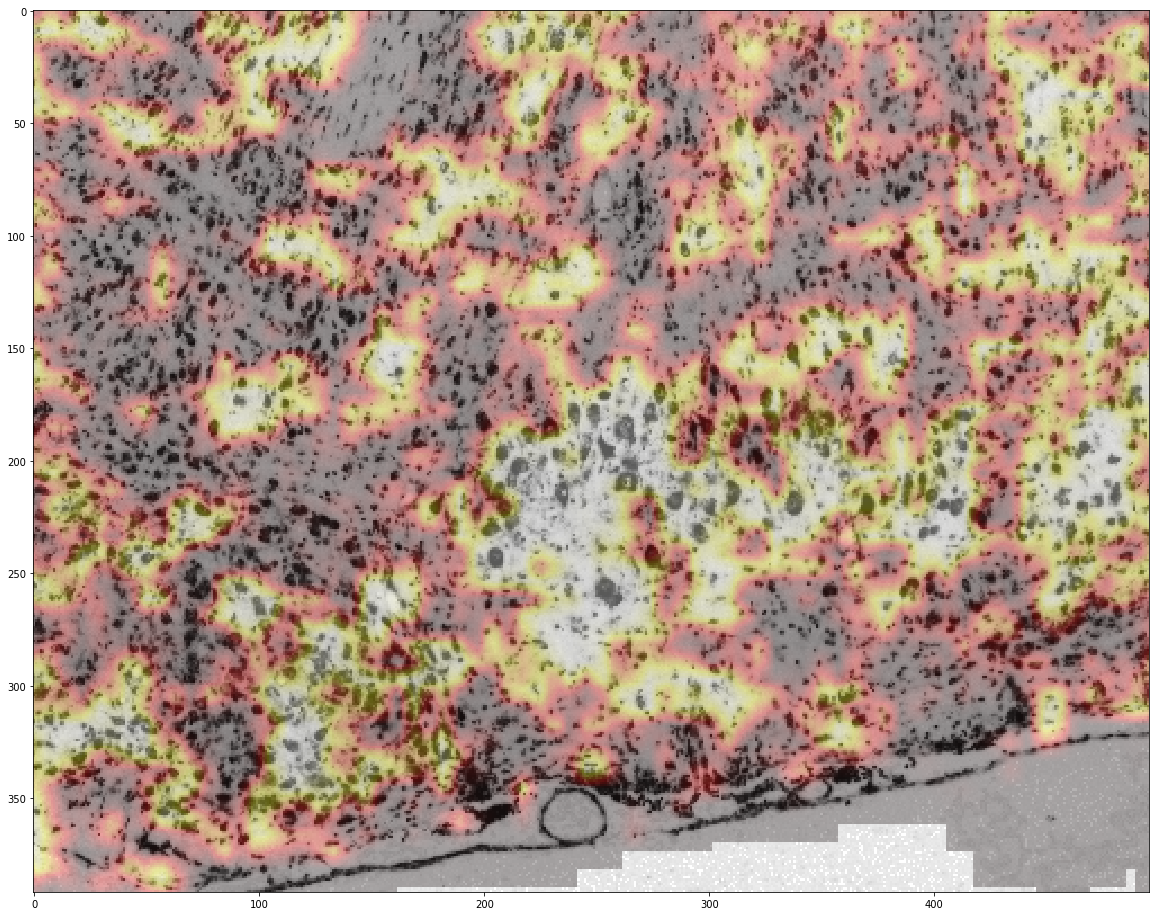

In [47]:
ntb_scviz = scoremap_overlay_on(bg='original', stack=stack, structure='7N', 
                                  in_downscale=1, out_downscale=scoremap_downscale, 
                                  classifier_id=37, sec=ntb_sec,
                                 overlay_alpha=.3)

plt.figure(figsize=(20,20));
plt.imshow(ntb_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
                     region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]);

In [48]:
ntb_lin_scviz = scoremap_overlay_on(bg='original', stack=stack, structure='7N', 
                                  in_downscale=1, out_downscale=scoremap_downscale, 
                                  classifier_id=80, sec=ntb_sec,
                                 overlay_alpha=.3)

plt.figure(figsize=(20,20));
plt.imshow(ntb_lin_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
                     region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]);

TypeError: cannot concatenate 'str' and 'NoneType' objects

In [ ]:
plt.figure(figsize=(10,5));
for a in ntb_matched_values_all_examples:
    plt.plot(ntb_values, a);
plt.xlim([0,5000]);
plt.ylim([0,256]);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Matched nissl intensity');
plt.show();

# A full neurotrace stack, compare nonlinear and linear normalized

In [ ]:
# Assume both nonlinear and linear normalized neurotrace images are already computed

In [ ]:
stack = 'MD635'

In [ ]:
for fn in metadata_cache['valid_filenames'][stack][100:105]:
    img_nonlin = DataManager.load_image(stack=stack, fn=fn, resol='lossless', version='cropped_gray')
    img_lin = DataManager.load_image(stack=stack, fn=fn, resol='lossless', version='cropped_gray_linearNormalized')
    
    region_x = 233 * 32
    region_y = 299 * 32
    region_w = 124 * 32
    region_h = 98 * 32

    region_nonlin = img_nonlin[region_y:region_y+region_h, region_x:region_x+region_w]
    region_lin = img_lin[region_y:region_y+region_h, region_x:region_x+region_w]
    
#     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));

#     axes[0].imshow(region_nonlin, plt.cm.gray);
#     axes[0].set_title('Neurotrace (nonlinearly normalized)');
#     axes[0].axis('off');

#     axes[1].imshow(region_lin, plt.cm.gray);
#     axes[1].set_title('Neurotrace (linearly normalized)');
#     axes[1].axis('off');
#     plt.show();    
    
    plt.figure(figsize=(20,20));
    plt.imshow(region_nonlin, plt.cm.gray);
    plt.title('Neurotrace Image (nonlinearly Normalized), %s' % fn);
    plt.axis('off');
    plt.show();

    plt.figure(figsize=(20,20));
    plt.imshow(region_lin, plt.cm.gray);
    plt.title('Neurotrace Image (linearly Normalized), %s' % fn);
    plt.axis('off');
    plt.show();

# Same images, different regions. nissl-nissl

In [ ]:
# nissl2_matched_values_all_examples = defaultdict(list)
# region_bboxes_all_examples = defaultdict(list)

for nissl_sec, nissl2_sec in compare_pairs[45:]:
    
    nissl2_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []

    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    for region_id in range(10):

        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break

        t = time.time()
        
        nissl2_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl2_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl2_im_fp)
        nissl2_im = imread(nissl2_im_fp)
        nissl2_region1 = img_as_ubyte(rgb2gray(nissl2_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl2_gray_bins = np.arange(0, 257)
        nissl2_gray_hist = np.histogram(nissl2_region1.flatten(), bins=nissl2_gray_bins)[0]
        
        sys.stderr.write('Load Nissl2: %.2f seconds.\n' % (time.time()-t))
        
        t = time.time()

        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
        
        sys.stderr.write('Load Nissl1: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        nissl2_region1_hist_matched = hist_match(nissl2_region1, nissl_region1)

    #     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    #     axes[0].imshow(nissl_region1, plt.cm.gray);
    #     axes[0].set_title('Nissl1');
    #     axes[1].imshow(nissl2_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    #     axes[1].set_title('Nissl2 (histogram matched to Nissl1)');
    #     plt.show();

        nissl2_to_nissl = {}
        for nissl2_v in nissl2_gray_bins[:-1]:
            a = nissl2_region1_hist_matched[nissl2_region1 == nissl2_v]
            if len(a) > 0:
                nissl2_to_nissl[nissl2_v] = np.unique(a)[0]

        nissl2_values = np.arange(0, 257)
        nissl2_matched_values = np.interp(nissl2_values, 
                                       [nissl2_v for nissl2_v, nissl_v in sorted(nissl2_to_nissl.items())], 
                                       [nissl_v for nissl2_v, nissl_v in sorted(nissl2_to_nissl.items())])
        
        nissl2_matched_values_all_examples_one_section.append(nissl2_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))

#         nissl2_matched_values_all_examples[(nissl_sec, nissl2_sec)].append(nissl2_matched_values)
#         region_bboxes_all_examples[(nissl_sec, nissl2_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))

        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'nissl_%d_to_nissl_%d_matched_values.npy' % (nissl2_sec, nissl_sec))
    np.save(fp, nissl2_matched_values_all_examples_one_section)
    upload_to_s3(fp)
        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'nissl_%d_to_nissl_%d_region_bboxes.npy' % (nissl2_sec, nissl_sec))
    np.save(fp,  np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp)
        
#         plt.plot(nissl2_values, nissl2_matched_values);
#         plt.xlim([0,256]);
#         plt.ylim([0,256]);
#         plt.xlabel('Nissl2 intensity');
#         plt.ylabel('Matched nissl1 intensity');
#         plt.show();

In [ ]:
# plt.figure(figsize=(10,5));
# for a in nissl2_matched_values_all_examples:
#     plt.plot(nissl2_values, a);
# plt.xlim([0,256]);
# plt.ylim([0,256]);
# plt.xlabel('Nissl1 intensity');
# plt.ylabel('Nissl2 matched to Nissl1 intensity');
# plt.show();

In [ ]:
for (nissl_sec, nissl2_sec), matched_values in sorted(nissl2_matched_values_all_examples.items()):
    plt.figure(figsize=(5,5));
    for a in matched_values:
        plt.plot(nissl2_values, a);
    plt.xlim([0,256]);
    plt.ylim([0,256]);
    plt.xlabel('Nissl1 intensity');
    plt.ylabel('Nissl2 matched to Nissl1 intensity');
    plt.title('%d, %d' % (nissl_sec, nissl2_sec));
    plt.axis('equal');
    plt.show();

In [ ]:
plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
plt.xlabel('Nissl intensity');
plt.show();

plt.bar(ntb_blue_bins[:-1], ntb_blue_hist);
plt.xlabel('Neurotrace blue intensity');
plt.show();

# Whole-image histogram

In [ ]:
info = {}
for sec in range(first_sec, last_sec+1):
    print sec
    fn = sec2fn[sec]
#     im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    green = im[..., 1]
    gf = green.flatten()
    blue = im[..., 2]
    bf = blue.flatten()
    info[sec] = {'gmax': green.max(),
    'bmax': blue.max(),
    'g99.99': np.percentile(gf, 99.99),
    'g99.999': np.percentile(gf, 99.999),
    'g99.9999': np.percentile(gf, 99.9999),
    'b99.99': np.percentile(bf, 99.99),
    'b99.999': np.percentile(bf, 99.999),
    'b99.9999': np.percentile(bf, 99.9999)}

In [ ]:
d = DataFrame(info).T

In [ ]:
plt.figure();
plt.stem(d['b99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['b99.999'], markerfmt='go', label='99.999');
plt.stem(d['b99.99'], markerfmt='bo', label='99.99');
plt.title('Blue channel percentile');
plt.legend();

plt.figure();
plt.stem(d['g99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['g99.999'], markerfmt='go', label='99.999');
plt.stem(d['g99.99'], markerfmt='bo', label='99.99');
plt.title('Green channel percentile');
plt.legend();

# Contrast Stretch Neurotrace Blue

In [ ]:
from skimage.exposure import rescale_intensity

In [ ]:
red = im[..., 0]
green = im[..., 1]
blue = im[..., 2]

In [ ]:
im.shape

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(int(np.ceil(len(ys)*len(xs)/5)), 5, sharex=True, sharey=True, figsize=(20, 10))
axes = axes.flatten()

c = 0
for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[c].bar(left_edges[:-1], np.log(count), width=.1);
        c += 1
        
plt.show();

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(len(ys), len(xs), sharex=True, sharey=True, figsize=(20, 10))

for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[yi][xi].bar(left_edges[:-1], np.log(count), width=.1);
        
plt.show();

In [ ]:
im.shape

In [ ]:
y = 7000
x = 13000
b = blue[y:y+1000,x:x+1000]
count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
plt.bar(left_edges[:-1], np.log(count), width=.1);
plt.show();

In [ ]:
x = 27232
y = 14752
w = 3552
h = 2784

In [ ]:
imin_red = 0
imax_red = 400

In [ ]:
red_out = rescale_intensity(im[y:y+h, x:x+w], in_range=(imin_red, imax_red), out_range=np.uint8)

In [ ]:
im = imread(args.input_fp)[..., :3]
im_out = rescale_intensity(im, in_range=(args.imin, args.imax), out_range=np.uint8)
imsave(args.output_fp, im_out)

In [ ]:
display_image(red_out)

In [ ]:
imin_blue = 0
imax_blue = 400

In [ ]:
blue_out = rescale_intensity(blue[y:y+h, x:x+w], in_range=(imin_blue, imax_blue), out_range=np.uint8)

In [ ]:
display_image(blue_out)

In [ ]:
imin_green = 0
imax_green = 400

In [ ]:
green_out = rescale_intensity(green[y:y+h, x:x+w], in_range=(imin_green, imax_green), out_range=np.uint8)

In [ ]:
display_image(green_out)

In [ ]:
from skimage.exposure import adjust_gamma

In [ ]:
blue_out_gamma = adjust_gamma(blue_out, .5)

In [ ]:
display_image(blue_out_gamma[8000:11000, 8000:11000])

In [ ]:
for sec in range(first_sec, last_sec+1, 5):
# for sec in [132]: # example blue, random region
# for sec in [120]: # has good green
    
    print sec
    fn = sec2fn[sec]
    im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    
#     plt.figure();
#     count, left_edges = np.histogram(im[...,2].flatten(), bins=np.arange(im[...,2].min(), im[...,2].max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram before contrast stretching');
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_pre_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imin = 0
    imax = 68
#     imax = np.percentile(im.flatten(), 99.9999)
#     print imax

#     im_flattened = im.flatten()
#     clip_values = {clip_perc: np.percentile(im_flattened, 100.-clip_perc) for clip_perc in [1e-4, 1e-5, 1e-6]}
    
#     imax = clip_values[1e-5]
#     print imax

    im_out = rescale_intensity(im[...,2], in_range=(imin, imax), out_range=np.uint8)
    
#     plt.figure();
#     count, left_edges = np.histogram(im_out.flatten(), bins=np.arange(im_out.min(), im_out.max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram after contrast stretching, clip=%d' % imax);
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_post_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imsave('/home/yuncong/csd395/ntb_histograms/small/%(fn)s_post_stretch.tif' % dict(fn=fn), 
           im_out[::10, ::10].astype(np.uint8))
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_B.tif' % dict(fn=fn), 
#            im_out[8030:8030+920, 15650:15650+1490].astype(np.uint16)) # random blue region
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_G.tif' % dict(fn=fn), 
#            im_out[7863:7863+1256, 108440:10844+1303].astype(np.uint8))